# Flatiron School: Use your regression skills to save the Galaxy

### InClass prediction Competition

### 1. Obtaining the Data

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('train.csv')
df.shape

(11703, 13)

In [3]:
df.head()

,Id,NA_Sales,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,0.00,PSP,2008.0,Misc,Sony Computer Entertainment,0.06,81.0,49.0,8.3,62.0,SCE Japan Studio,E
1,1,0.72,2600,1982.0,Shooter,Atari,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.11,XB,2004.0,Action,THQ,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.15,X360,2008.0,Fighting,Electronic Arts,0.00,54.0,57.0,6.3,19.0,EA Canada,T
4,4,0.00,DS,2006.0,Action,Namco Bandai Games,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 13 columns):
Id                 11703 non-null int64
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
Publisher          11664 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         7011 non-null object
User_Count         5332 non-null float64
Developer          7066 non-null object
Rating             6978 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 1.2+ MB


In [5]:
# why is user score stored as string?
df.User_Score.unique()

array(['8.3', nan, '6.3', 'tbd', '7.7', '2.8', '8.2', '9', '4.3', '7.2',
       '8.5', '7.6', '7.5', '8.1', '6.1', '7', '6.7', '7.4', '7.9', '5.4',
       '7.8', '5.2', '8.6', '4', '5', '8.7', '6.8', '4.1', '6.4', '6.6',
       '9.3', '7.3', '5.7', '4.2', '2.7', '3.8', '3', '8', '6.2', '8.8',
       '4.4', '7.1', '3.6', '5.5', '4.5', '8.4', '5.9', '6', '5.3', '0.5',
       '8.9', '6.5', '3.2', '9.1', '5.8', '5.6', '4.9', '6.9', '2.4',
       '9.5', '3.7', '3.3', '3.9', '2.6', '2.9', '9.2', '1.8', '4.6',
       '3.4', '4.8', '4.7', '5.1', '9.4', '3.1', '2.5', '3.5', '2.2',
       '2.1', '1.9', '9.7', '1.4', '1.7', '0', '0.3', '1.5', '1', '9.6',
       '2', '1.6', '1.2', '0.9', '0.7', '0.6', '2.3', '1.3', '0.2'],
      dtype=object)

In [6]:
# replace 'tbd'
df['User_Score'].replace(to_replace='tbd', value=np.nan, inplace=True)

# convert string values into numeric values
df['User_Score'] = pd.to_numeric(df['User_Score'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 13 columns):
Id                 11703 non-null int64
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
Publisher          11664 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         5332 non-null float64
User_Count         5332 non-null float64
Developer          7066 non-null object
Rating             6978 non-null object
dtypes: float64(7), int64(1), object(5)
memory usage: 1.2+ MB


In [7]:
df.duplicated().sum()

0

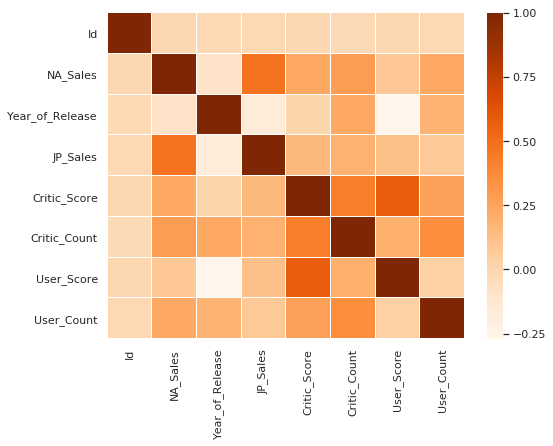

In [8]:
plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(), cmap="Oranges", linewidths=0.1);

As the columns `Publisher` and `Developer` contain way too many values and also doesn't seem to add any reasonable value to our prediction, let's drop them. Together with the `Id` that's not needed either.

The column `Critic_Count` mirrors the number of critics used in coming up with the `Critic_Score`, meaning double data. The same is true for `User_Count` that adds to `User_Score`. Let's drop both simply counting columns.

In [9]:
#df = df.drop(['Id', 'Publisher', 'Developer', 'Year_of_Release'], axis=1)
df = df.drop(['Id', 'Publisher', 'Developer'], axis=1)

### 2. Preprocessing the Data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 10 columns):
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         5332 non-null float64
User_Count         5332 non-null float64
Rating             6978 non-null object
dtypes: float64(7), object(3)
memory usage: 914.4+ KB


The problem is we have tons of missing values! What to do? Let's walk through each of these features:

**2.1. Handling `Rating` column**

In [11]:
df.Rating.unique()

array(['E', nan, 'T', 'M', 'E10+', 'EC', 'RP', 'K-A'], dtype=object)

In [12]:
df.Rating.value_counts()

E       2791
T       2069
M       1109
E10+    1000
EC         5
K-A        2
RP         2
Name: Rating, dtype: int64

According to [Wikipedia](https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board) ....

In [13]:
def value_replacement(col, to_replace, new_value):
    col.replace(to_replace, new_value, inplace=True)

In [14]:
value_replacement(df.Rating, to_replace='EC', new_value='E')
value_replacement(df.Rating, to_replace='K-A', new_value='E')
value_replacement(df.Rating, to_replace='RP', new_value='None')
value_replacement(df.Rating, to_replace=np.nan, new_value='None')

df.Rating.value_counts()

None    4727
E       2798
T       2069
M       1109
E10+    1000
Name: Rating, dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 10 columns):
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         5332 non-null float64
User_Count         5332 non-null float64
Rating             11703 non-null object
dtypes: float64(7), object(3)
memory usage: 914.4+ KB


**2.2. Handling `Year_of_release` column**

In [16]:
df1 = df[df['Year_of_Release'].isna()]
df1.tail(10)

,NA_Sales,Platform,Year_of_Release,Genre,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
11020,0.59,PS2,NaN,Sports,0.04,84.0,20.0,6.4,76.0,E
11064,0.58,PC,NaN,Shooter,0.00,81.0,29.0,5.2,1651.0,M
11202,0.11,Wii,NaN,Misc,0.77,NaN,NaN,NaN,NaN,None
11213,0.15,X360,NaN,Action,0.00,60.0,9.0,3.6,138.0,T
11298,0.01,DS,NaN,Platform,0.00,NaN,NaN,NaN,NaN,E10+
11380,0.00,PS3,NaN,Racing,0.01,68.0,24.0,4.5,4.0,None
11390,0.26,GBA,NaN,Action,0.00,NaN,NaN,NaN,NaN,None
11421,0.13,X360,NaN,Puzzle,0.00,78.0,13.0,8.4,11.0,E
11474,0.22,XB,NaN,Shooter,0.00,85.0,54.0,8.2,21.0,M
11615,0.00,Wii,NaN,Shooter,0.02,NaN,NaN,NaN,NaN,None


In [17]:
df.Year_of_Release.max()

2017.0

In [18]:
#df.Year_of_Release.describe()

In [19]:
#df.Year_of_Release.hist(bins=20);

It might be reasonable to bin the years into periods of roughly 5 years and when doing this, also bin the NaN values into *unknown*.

In [20]:
# bin the year_of_release into periods_of_release
bins = [1980, 1995, 2000, 2005, 2010, 2015, 2017]
labels = ['Before 1995', '1995-2000', '2000-2005', '2005-2010', '2010-2015', '2015-2017']
df['Periods_of_Release'] = pd.cut(df['Year_of_Release'], bins=bins, labels=labels)

# create another category for the unknown release date
df['Periods_of_Release'].replace(to_replace=np.nan, value='Unknown', inplace=True)

In [21]:
#df.Periods_of_Release.unique()

In [22]:
df.Periods_of_Release.value_counts()

2005-2010      4471
2000-2005      2627
2010-2015      2463
1995-2000      1121
Before 1995     472
2015-2017       360
Unknown         189
Name: Periods_of_Release, dtype: int64

In [23]:
# visualize the distribution of categories
#order = ['Unknown', '2015-2017', '2010-2015', '2005-2010',  '2000-2005','1995-2000', 'Before 1995']
#df.Periods_of_Release.value_counts().loc[order].plot(kind='barh');

In [24]:
# drop the original year related column
df = df.drop(['Year_of_Release'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 10 columns):
NA_Sales              11703 non-null float64
Platform              11703 non-null object
Genre                 11701 non-null object
JP_Sales              11703 non-null float64
Critic_Score          5697 non-null float64
Critic_Count          5697 non-null float64
User_Score            5332 non-null float64
User_Count            5332 non-null float64
Rating                11703 non-null object
Periods_of_Release    11703 non-null object
dtypes: float64(6), object(4)
memory usage: 914.4+ KB


**2.3. Handling `User_Score` column**

In [25]:
df.User_Score.describe()

count    5332.000000
mean        7.125075
std         1.491034
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: User_Score, dtype: float64

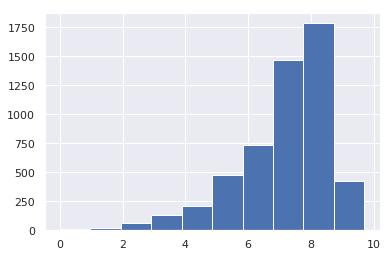

In [26]:
df.User_Score.hist();

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 10 columns):
NA_Sales              11703 non-null float64
Platform              11703 non-null object
Genre                 11701 non-null object
JP_Sales              11703 non-null float64
Critic_Score          5697 non-null float64
Critic_Count          5697 non-null float64
User_Score            5332 non-null float64
User_Count            5332 non-null float64
Rating                11703 non-null object
Periods_of_Release    11703 non-null object
dtypes: float64(6), object(4)
memory usage: 914.4+ KB


*Create Sub-Datasets*

In [28]:
# filter out sub_df to work with
sub_df = df[['NA_Sales', 'Platform', 'Genre', 'JP_Sales', 'Rating', 'Periods_of_Release', 'User_Score']]
sub_df.dropna(subset=['Genre'], inplace=True)
#sub_df.info()

In [29]:
# deal with categorical columns
sub_df['Platform'] = sub_df['Platform'].astype('category')
sub_df['Genre'] = sub_df['Genre'].astype('category')
sub_df['Rating'] = sub_df['Rating'].astype('category')
sub_df['Periods_of_Release'] = sub_df['Periods_of_Release'].astype('category')
sub_df = pd.get_dummies(sub_df)

In [30]:
# split datasets
train_data = sub_df[sub_df['User_Score'].notnull()]
test_data  = sub_df[sub_df['User_Score'].isnull()]

# define X
X_train = train_data.drop('User_Score', axis=1)
X_test  = test_data.drop('User_Score', axis=1)

# define y
y_train = train_data['User_Score']

print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (5332, 58)
Shape of Test Data:     (6369, 58)

Shape of X_train: (5332, 57)
Shape of X_test: (6369, 57)

Shape of y_train: (5332,)


*Scaling the Features*

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

*Implementing GridSearch*

In [176]:
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import mean_squared_error 
#from math import sqrt

params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
model.best_params_

{'n_neighbors': 9}

In [33]:
from sklearn.neighbors import KNeighborsRegressor

# fit KNN
neighbor = KNeighborsRegressor(n_neighbors=9, weights='distance')
neighbor.fit(X_train, y_train)

# Predict missing values' class
y_test = neighbor.predict(X_test)

# preparing y_test
y_test = pd.DataFrame(y_test)
y_test.columns = ['User_Score']
print(y_test.shape)
y_test.head(2)

(6369, 1)


,User_Score
0,7.142151
1,7.755556


In [39]:
from fancyimpute import KNN

# X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN

# Use 3 nearest rows which have a feature to fill in each row's missing features
X_filled_knn = KNN(k=9).fit_transform(test_data)

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/fancyimpute/solver.py:58: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/6369 with 0 missing, elapsed time: 19.846
Imputing row 101/6369 with 0 missing, elapsed time: 19.846
Imputing row 201/6369 with 0 missing, elapsed time: 19.847
Imputing row 301/6369 with 0 missing, elapsed time: 19.847
Imputing row 401/6369 with 0 missing, elapsed time: 19.847
Imputing row 501/6369 with 0 missing, elapsed time: 19.848
Imputing row 601/6369 with 0 missing, elapsed time: 19.848
Imputing row 701/6369 with 0 missing, elapsed time: 19.849
Imputing row 801/6369 with 0 missing, elapsed time: 19.849
Imputing row 901/6369 with 0 missing, elapsed time: 19.849
Imputing row 1001/6369 with 0 missing, elapsed time: 19.849
Imputing row 1101/6369 with 0 missing, elapsed time: 19.850
Imputing row 1201/6369 with 0 missing, elapsed time: 19.851
Imputing row 1301/6369 with 0 missing, elapsed time: 19.851
Imputing row 1401/6369 with 0 missing, elapsed time: 19.851
Imputing row 1501/6369 with 0 missing, elapsed time: 19.852
Imputing row 1601/6369 with 0 missing, elapsed time:

In [40]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,User_Score
0,0.024759,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.142151
1,0.003783,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.755556
2,0.000000,0.001389,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.955555
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.411111
4,0.001032,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.859082


In [34]:
# preparing X_test
print(X_test.shape)
X_test.head(2)

(6369, 57)


,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,0.024759,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.003783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)

# finally combine the new test data
test_data = pd.concat([X_test, y_test], axis=1)
test_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,User_Score
0,0.024759,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.142151
1,0.003783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.755556


In [36]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([test_data, train_data], axis=0, sort=True)
sub_df_new = sub_df_new[['User_Score']]

print(sub_df_new.shape)
sub_df_new.head(2)

(11701, 1)


,User_Score
0,7.142151
1,7.755556


In [37]:
# drop duplicate columns in original dataframe before concatening 
df.drop(['User_Score'], axis=1, inplace=True)
#sub_df_new = sub_df_new['User_Score'].set_index()

# concatenate back to complete dataframe
df = pd.concat([sub_df_new, df], axis=1)

print(df.shape)
df.head(2)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [297]:
df.User_Score.isna().sum()

0

In [298]:
df.User_Score.describe()

count    11703.000000
mean         7.135925
std          1.018505
min          0.000000
25%          7.084982
50%          7.097680
75%          7.472268
max         11.656222
Name: User_Score, dtype: float64

In [299]:
# to maintain the original distribution, let's drop all records over the original max threshold
df = df.drop(df[(df['User_Score'] > 9.7) ].index, axis=0)
df.User_Score.describe()

count    11695.000000
mean         7.133644
std          1.014949
min          0.000000
25%          7.084982
50%          7.097680
75%          7.456395
max          9.700000
Name: User_Score, dtype: float64

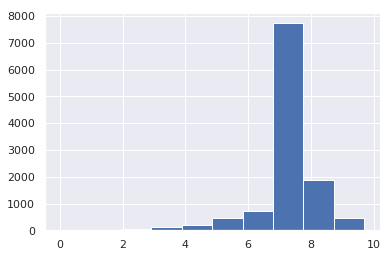

In [300]:
df.User_Score.hist();

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11695 entries, 0 to 11702
Data columns (total 8 columns):
JP_Sales              11695 non-null float64
User_Score            11695 non-null float64
NA_Sales              11695 non-null float64
Platform              11695 non-null object
Genre                 11693 non-null object
Critic_Score          5697 non-null float64
Rating                11695 non-null object
Periods_of_Release    11695 non-null object
dtypes: float64(4), object(4)
memory usage: 822.3+ KB


**2.4. Handling `Critic_Score` column**

In [302]:
df.Critic_Score.describe()

count    5697.000000
mean       68.909602
std        14.052323
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: Critic_Score, dtype: float64

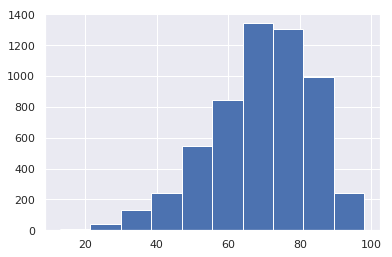

In [303]:
df.Critic_Score.hist();

In [304]:
# filter out sub_df to work with
sub_df = df[[ 'JP_Sales', 'Critic_Score']]

# split datasets
train_data = sub_df[sub_df['Critic_Score'].notnull()]
test_data  = sub_df[sub_df['Critic_Score'].isnull()]

# define X
X_train = train_data.drop('Critic_Score', axis=1)
X_test  = test_data.drop('Critic_Score', axis=1)

# define y
y_train = train_data['Critic_Score']

print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (5697, 2)
Shape of Test Data:     (5998, 2)

Shape of X_train: (5697, 1)
Shape of X_test: (5998, 1)

Shape of y_train: (5697,)


In [305]:
# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

# making predictions
y_test = linreg.predict(X_test)

In [306]:
# preparing y_test
y_test = pd.DataFrame(y_test)
y_test.columns = ['Critic_Score']
print(y_test.shape)
y_test.head(2)

(5998, 1)


,Critic_Score
0,68.456947
1,68.456947


In [307]:
# preparing X_test
print(X_test.shape)
X_test.head(2)

(5998, 1)


,JP_Sales
1,0.0
2,0.0


In [308]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)

# finally combine the new test data
test_data = pd.concat([X_test, y_test], axis=1)
test_data.head(2)

,JP_Sales,Critic_Score
1,0.0,68.456947
2,0.0,68.456947


In [309]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([test_data, train_data], axis=0, sort=True)

print(sub_df_new.shape)
sub_df_new.head(2)

(11695, 2)


,Critic_Score,JP_Sales
1,68.456947,0.0
2,68.456947,0.0


In [310]:
# drop duplicate columns in original dataframe before concatening 
df.drop(['JP_Sales', 'Critic_Score'], axis=1, inplace=True)

# concatenate back to complete dataframe
df = pd.concat([sub_df_new, df], axis=1)

print(df.shape)
df.head(2)

(11695, 8)


,Critic_Score,JP_Sales,User_Score,NA_Sales,Platform,Genre,Rating,Periods_of_Release
0,81.000000,0.06,8.300000,0.00,PSP,Misc,E,2005-2010
1,68.456947,0.00,7.084982,0.72,2600,Shooter,None,Before 1995


In [311]:
df.Critic_Score.isna().sum()

0

In [312]:
df.Critic_Score.describe()

count    11695.000000
mean        69.047233
std          9.931078
min         13.000000
25%         68.456947
50%         68.533962
75%         72.000000
max         98.954911
Name: Critic_Score, dtype: float64

In [313]:
df = df.drop(df[(df['Critic_Score'] > 98.) ].index, axis=0)
df.Critic_Score.describe()

count    11693.000000
mean        69.042197
std          9.924455
min         13.000000
25%         68.456947
50%         68.533962
75%         72.000000
max         98.000000
Name: Critic_Score, dtype: float64

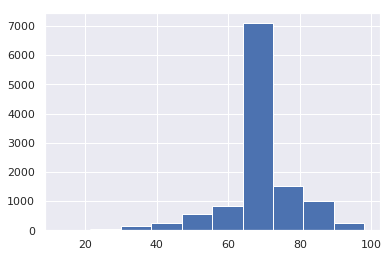

In [314]:
df.Critic_Score.hist();

In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11693 entries, 0 to 11702
Data columns (total 8 columns):
Critic_Score          11693 non-null float64
JP_Sales              11693 non-null float64
User_Score            11693 non-null float64
NA_Sales              11693 non-null float64
Platform              11693 non-null object
Genre                 11691 non-null object
Rating                11693 non-null object
Periods_of_Release    11693 non-null object
dtypes: float64(4), object(4)
memory usage: 822.2+ KB


**2.5. Handling `Genre` column**

In [316]:
df = df.dropna(subset=['Genre'], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11691 entries, 0 to 11702
Data columns (total 8 columns):
Critic_Score          11691 non-null float64
JP_Sales              11691 non-null float64
User_Score            11691 non-null float64
NA_Sales              11691 non-null float64
Platform              11691 non-null object
Genre                 11691 non-null object
Rating                11691 non-null object
Periods_of_Release    11691 non-null object
dtypes: float64(4), object(4)
memory usage: 822.0+ KB


**2.6. Handling `Platform` column**

In [317]:
df.Platform.value_counts()

PS2     1519
DS      1519
PS3      966
Wii      898
X360     890
PSP      876
PS       820
PC       663
XB       559
GBA      550
GC       386
3DS      374
PSV      310
PS4      285
N64      219
XOne     168
SNES     165
SAT      121
WiiU     103
2600      89
NES       68
GB        62
DC        39
GEN       19
WS         6
NG         6
SCD        5
3DO        3
TG16       1
PCFX       1
GG         1
Name: Platform, dtype: int64

In [318]:
#df.drop(df[(df.Platform.value_counts() < 100)].index, axis=0, inplace=True)
df = df.groupby('Platform').filter(lambda x: len(x) > 100)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11391 entries, 0 to 11702
Data columns (total 8 columns):
Critic_Score          11391 non-null float64
JP_Sales              11391 non-null float64
User_Score            11391 non-null float64
NA_Sales              11391 non-null float64
Platform              11391 non-null object
Genre                 11391 non-null object
Rating                11391 non-null object
Periods_of_Release    11391 non-null object
dtypes: float64(4), object(4)
memory usage: 800.9+ KB


In [319]:
df.Platform.value_counts()

PS2     1519
DS      1519
PS3      966
Wii      898
X360     890
PSP      876
PS       820
PC       663
XB       559
GBA      550
GC       386
3DS      374
PSV      310
PS4      285
N64      219
XOne     168
SNES     165
SAT      121
WiiU     103
Name: Platform, dtype: int64

## 3. Machine Learning

*Preparing Target & Features*

In [320]:
# define our features 
features = df.drop(["NA_Sales"], axis=1)

# define our target
target = df[["NA_Sales"]]

*Recoding Categorical Features*

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11391 entries, 0 to 11702
Data columns (total 8 columns):
Critic_Score          11391 non-null float64
JP_Sales              11391 non-null float64
User_Score            11391 non-null float64
NA_Sales              11391 non-null float64
Platform              11391 non-null object
Genre                 11391 non-null object
Rating                11391 non-null object
Periods_of_Release    11391 non-null object
dtypes: float64(4), object(4)
memory usage: 800.9+ KB


In [322]:
# convert string values in object columns into categorical values
df['Platform'] = df['Platform'].astype('category')
df['Genre'] = df['Genre'].astype('category')
df['Rating'] = df['Rating'].astype('category')
df['Periods_of_Release'] = df['Periods_of_Release'].astype('category')
#df['Platform_Groups'] = df['Platform_Groups'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11391 entries, 0 to 11702
Data columns (total 8 columns):
Critic_Score          11391 non-null float64
JP_Sales              11391 non-null float64
User_Score            11391 non-null float64
NA_Sales              11391 non-null float64
Platform              11391 non-null category
Genre                 11391 non-null category
Rating                11391 non-null category
Periods_of_Release    11391 non-null category
dtypes: category(4), float64(4)
memory usage: 491.2 KB


In [323]:
# create dummy variables of all categorical features
features = pd.get_dummies(features)

*Train-Test-Split*

In [324]:
# import train_test_split function
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

*Scaling the Data*

In [325]:
# scale data
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test  = sc.transform(X_test)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


*XGBoost*

In [326]:
# create a baseline
booster = xgb.XGBRegressor()

In [262]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}


In [327]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, 
                           max_depth=7, n_estimators=100, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test  = booster.predict(X_test)

In [328]:
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

r2 = r2_score(y_test, y_pred_test)
print(f"r2: {round(r2, 4)}")

RMSE: 0.8258
r2: 0.4873


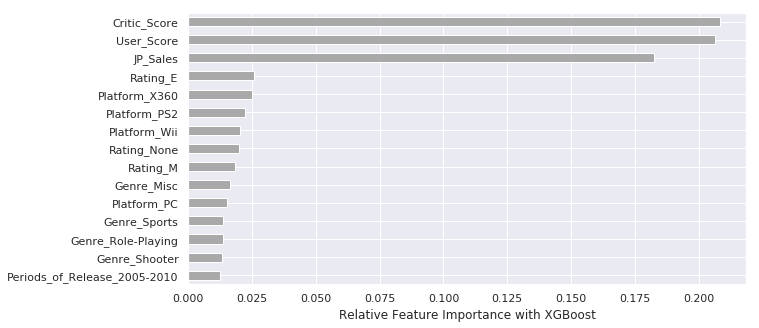

In [197]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');